# Multiclass Classification Metrics

Let's expand our model diagnostic toolbox to account for classification problems with more than one possible outcome.

## What we will accomplish

In this notebook we will:
- Discuss how to assess multiclass classifiers,
- Expand the confusion matrix to account for more than two classes and
- Introduce cross-entropy.

In [2]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a dark background
sns.set_style("whitegrid")

## Making multiclass into binary

The first way you may evaluate a multiclass model is to turn it into a binary model.

Sometimes there may be a couple of classes that you are most interested in, in which case you can just focus on optimizing the performance of binary classifier metrics on those classes.

For example, the Cleveland Heart Disease data set, <a href="https://archive.ics.uci.edu/ml/datasets/heart+disease">https://archive.ics.uci.edu/ml/datasets/heart+disease</a>, provides four possible heart disease outcomes, but perhaps we are most interested in the most serious heart disease classification or the case where someone does not have heart disease.

## Multiclass confusion matrix

Whether we are interested in a couple of classes or all of the classes we can still gather useful information from the confusion matrix. The confusion matrix we introduced earlier naturally extends to more than two possible classes.

<img src="lecture_9_assets/conf_mat_multi.png" width="70%"></img>

However, in this setting we lose our ability to interpret things like true positive rate, false positve rate, etc.

Let's see this in action in `sklearn`.

In [3]:
from sklearn.datasets import load_iris

In [4]:
iris = load_iris(as_frame=True)

X = iris['data']
X = X.rename(columns={'sepal length (cm)':'sepal_length',
                         'sepal width (cm)':'sepal_width',
                         'petal length (cm)':'petal_length',
                         'petal width (cm)':'petal_width'})
y = iris['target']

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y,
                                                       shuffle=True,
                                                       random_state=413,
                                                       test_size=.2,
                                                       stratify=y)

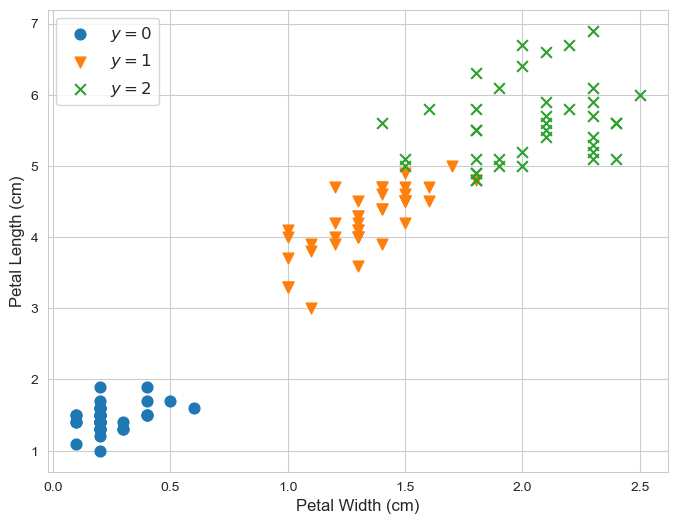

In [7]:
plt.figure(figsize=(8,6))

plt.scatter(X_train.loc[y_train==0].petal_width, 
                X_train.loc[y_train==0].petal_length,
                s = 60,
                label='$y=0$')
plt.scatter(X_train.loc[y_train==1].petal_width, 
                X_train.loc[y_train==1].petal_length,
                marker = 'v',
                s = 60,
                label='$y=1$')
plt.scatter(X_train.loc[y_train==2].petal_width, 
                X_train.loc[y_train==2].petal_length,
                marker = 'x',
                s = 60,
                label='$y=2$')

plt.xlabel("Petal Width (cm)", fontsize=12)
plt.ylabel("Petal Length (cm)", fontsize=12)
plt.legend(fontsize=12)

plt.show()

In [8]:
## import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [9]:
## Make LDA object
LDA = LinearDiscriminantAnalysis()

## Fit the model
LDA.fit(X_train[['petal_width', 'petal_length']], y_train)

LinearDiscriminantAnalysis()

In [10]:
## import confusion matrix
from sklearn.metrics import confusion_matrix

In [11]:
conf_mat = confusion_matrix(y_train, LDA.predict(X_train[['petal_width', 'petal_length']]))

In [12]:
pd.DataFrame(conf_mat,
                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2'],
                 index = ['Actual 0', 'Actual 1', 'Actual 2'])

,Predicted 0,Predicted 1,Predicted 2
Actual 0,40,0,0
Actual 1,0,38,2
Actual 2,0,2,38


## Cross-entropy (aka logistic Loss, log-loss, or softmax loss)

Assume that we have a probabilistic classifier with parameters $\theta$.  

For each $\theta$, the classifier takes a feature vector $x$ as input and returns the vector $P_\theta( y | x) = [P(y = 1 | x), P(y = 2 | x), \dots P(y = C | x)]$ as output.  For instance in a 3 class problem we might get the output $[0.2, 0.7, 0.1]$ to indicate the probability of each of the three classes. In sklearn this will be the output of the `.predict_proba` method applied to a single row matrix.

To match this convention, let's also output the actual class in the same format:  $[0,0,1]$ for example.  If you had originally had other some other convention (for example outputting the index $2$, or a name like 'iris-virginica'), the `pd.get_dummies` method will convert to the format we are talking about here.

If we have $n$ independent observations $(x_i, y_i)$, then the likelihood function is

$$
L(\theta) = \prod_{i=1}^n y_i \cdot P_\theta( y | \vec{x}_i)
$$

Note that if our classifier is predicting a literal $0$ for a class probability, and a training example actual has that class, then we get a $0$ likelihood.  To avoid this, most probabilistic classifiers are constructed in such a way that $0$ probabilities are impossible to output. For instance, in logistic regression the sigmoid function has range $(0,1)$, so a class probability of $0$ or $1$ is never returned.

Instead of maximizing the likelihood, we can minimize the negative log likelihood:

$$
\operatorname{NLL}(\theta) = -\sum_{i=1}^n \log( y_i \cdot P_\theta( y | \vec{x}_i))
$$

This is a little easier to vectorize if we rewrite it as 

$$
\operatorname{NLL}(\theta) = -\sum_{i=1}^n y_i \cdot \log( P_\theta( y | \vec{x}_i))
$$

where we are taking the logarithm of each component of $P_\theta( y | \vec{x}_i)$.  This is okay since none of these components are $0$, and since only one term ultimately contributes to the sum.

**This is the "cross entropy" of the classifier.**

Let's give one hand computable example.

<center>

| Actual Class | Predicted Probs |
|--------------|-----------------|
| $[1,0,0]$    | $[0.8,0.1,0.1]$ |
| $[0,0,1]$    | $[0.1,0.3,0.6]$ |
| $[0,1,0]$    | $[0.09,0.01,0.9]$ |

</center>

$$
\begin{align*}
\operatorname{CrossEntropy} 
&= - (\log(0.8) + \log(0.6) + \log(0.01))\\
&= - (-0.22 + -0.51 + -4.60)\\
&= 0.22 + 0.51 + 4.60\\
&= 5.34
\end{align*}
$$

Notice that cross-entropy "rewards" the classifier with when it is confidently correct (like the first observation), and "punishes" the classifier when it is confidently incorrect (like the last example).

Terry Tao proposes using cross-entropy as a way to score multiple choice examinations where the student is allowed to give a probability for each choice in [this blog post](https://terrytao.wordpress.com/2016/06/01/how-to-assign-partial-credit-on-an-exam-of-true-false-questions/comment-page-1/).  The derivation of cross entropy provided there might give you some additional intuition.  

Side Note:  I do not advocate implementing this grading strategy in real life!

Cross entropy is also called "logistic Loss" since it is the loss function used for logistic regression.  However, since it is also used for many other classification algorithms, calling it "logistic loss" (or "log-loss") is perhaps a bit anachronistic.

Let's see how to implement this "by hand" using Pandas and NumPy.

`ycs = pd.get_dummies(y_train).to_numpy()` will be an $n \times C$ matrix whose $i^{th}$ row is the vector $y_i$.

`pcs = LDA.predict_proba(X_train)` will be an $n \times C$ matrix whose $i^{th}$ row is $P(y | x_i)$

So we can calculate the cross entropy in a nice vectorized way as follows:

In [48]:
ycs = 1*pd.get_dummies(y_train).to_numpy()
pcs = LDA.predict_proba(X_train[['petal_width', 'petal_length']])
loss = - np.sum(ycs * np.log(pcs))
print(f"The cross entropy of this LDA classifier is{loss: .2f}")

The cross entropy of this LDA classifier is 8.13


Let's break down the line `- np.sum(ycs * np.log(pcs))` a bit:

In [28]:
#Showing ycs and pcs side by side
pd.DataFrame({'Class 0 Dummy': ycs[:,0], 'Class 1 Dummy': ycs[:,1], 'Class 2 dummy': ycs[:,2], 'Prob Class 0': np.round(pcs[:,0],2), 'Prob Class 1': np.round(pcs[:,1],2), 'Prob Class 2': np.round(pcs[:,2],2)})

,Class 0 Dummy,Class 1 Dummy,Class 2 dummy,Prob Class 0,Prob Class 1,Prob Class 2
0,0,1,0,0.0,0.96,0.04
1,0,0,1,0.0,0.00,1.00
2,0,1,0,0.0,1.00,0.00
3,0,1,0,0.0,1.00,0.00
4,1,0,0,1.0,0.00,0.00
...,...,...,...,...,...,...
115,1,0,0,1.0,0.00,0.00
116,1,0,0,1.0,0.00,0.00
117,0,1,0,0.0,1.00,0.00
118,1,0,0,1.0,0.00,0.00


In [29]:
#using ycs as a "mask" for pcs by multiplying componentwise (aka hadamard product)
pd.DataFrame(ycs * pcs, columns=['Masked prob 0', 'Masked prob 1', 'Masked prob 2'])

,Masked prob 0,Masked prob 1,Masked prob 2
0,0.0,0.956908,0.000000
1,0.0,0.000000,0.999985
2,0.0,0.999380,0.000000
3,0.0,0.999618,0.000000
4,1.0,0.000000,0.000000
...,...,...,...
115,1.0,0.000000,0.000000
116,1.0,0.000000,0.000000
117,0.0,0.996755,0.000000
118,1.0,0.000000,0.000000


In [44]:
# Same, but take the negative log of the probs

pd.DataFrame(-ycs * np.log(pcs), columns=['neg log prob 0', 'neg log prob 1', 'neg log prob 2'])

,neg log prob 0,neg log prob 1,neg log prob 2
0,-0.000000e+00,0.044048,-0.000000
1,-0.000000e+00,-0.000000,0.000015
2,-0.000000e+00,0.000620,-0.000000
3,-0.000000e+00,0.000382,-0.000000
4,2.450706e-12,-0.000000,-0.000000
...,...,...,...
115,8.524359e-11,-0.000000,-0.000000
116,8.000045e-12,-0.000000,-0.000000
117,-0.000000e+00,0.003250,-0.000000
118,6.133760e-12,-0.000000,-0.000000


In [36]:
# Taking the logs and summing.  Note that none of the predicted probabilities are *actually* zero, although they may be close, so log(0) isn't an issue.
- np.sum(ycs * np.log(pcs))

8.127982067830906

##### In `sklearn`

This can be done with `log_loss` in `sklearn`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html">https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html</a>.

In [18]:
## with sklearn
from sklearn.metrics import log_loss

In [19]:
## implement log_loss on the training set
## first put in the true values
## then the predicted probabilities
## labels are the labels for the three classes [0,1,2]
## normalize=False uses the log-loss formula we presented above
log_loss(y_train, pcs, labels=[0,1,2], normalize=False)

8.12798206783092

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)